**Общая информация:**
Последние несколько месяцев компания, выпускающая развлекательное приложение Procrastinate Pro+, несет убытки, несмотря на увеличение бюджета в рекламу. Необходимо установить причины убытков и найти возможные пути устранения проблемы. 

**Цель работы:**
Установить причины убытков и помочь компании выйти в плюс. Для этого предоставлена следующая информация:

- данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года,

- лог сервера с данными об их посещениях,

- выгрузка их покупок за этот период,

- рекламные расходы.

**Необходимо установить:**

- откуда приходят пользователи и какими устройствами они пользуются,

- сколько стоит привлечение пользователей из различных рекламных каналов,

- сколько денег приносит каждый клиент,

- когда расходы на привлечение клиента окупаются

- какие факторы мешают привлечению клиентов

### Загрузите данные и подготовьте их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [1]:
#Импортируем библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

#Загрузим данные из датасетов
visits=pd.read_csv('/datasets/visits_info_short.csv')
orders=pd.read_csv('/datasets/orders_info_short.csv')
costs=pd.read_csv('/datasets/costs_info_short.csv')

In [2]:
# Изучим информацию в таблицах
print('Таблица visits')
print(visits.info())
print('Таблица orders')
print(orders.info())
print('Таблица costs')
print(costs.info())

Таблица visits
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None
Таблица orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None
Таблица costs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 

- В датасетах отсутствуют пропущенные значения
- Названия столбцов не соответствуют правилам
- Данные в столбцах времени имеют вещественный формат, нужно заменить на формат даты

#### Приведем названия столбцов к стандартному стилю

In [3]:
#Удалим пробелы 
visits.columns = visits.columns.str.lower()
visits=visits.rename(columns={'user id':'user_id', 'session start':'session_start',\
                              'session end':'session_end'})
visits.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
#приведем к нижнему регистру
costs.columns = costs.columns.str.lower()
costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [5]:
#приведем к нижнему регистру
orders.columns = orders.columns.str.lower()
orders=orders.rename(columns={'user id':'user_id', 'event dt':'event_dt'})
orders.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


#### Изменим формат в колонках с датами

In [6]:
visits['session_start']=pd.to_datetime(visits['session_start'])
visits['session_end']=pd.to_datetime(visits['session_end'])

In [7]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [8]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

#### Проверим наличие дубликатов

In [9]:
#Поиск явных дубликатов
print('Количество явных дубликатов в visits:', visits.duplicated().sum())
print('Количество явных дубликатов в orders:', orders.duplicated().sum())
print('Количество явных дубликатов в costs:', costs.duplicated().sum())

Количество явных дубликатов в visits: 0
Количество явных дубликатов в orders: 0
Количество явных дубликатов в costs: 0


In [10]:
#Поиск неявных дубликатов 
print('Количество неявных дубликатов в visits:',\
      visits.duplicated(subset=['user_id', 'session_start', 'session_end']).sum())
print('Количество неявных дубликатов в orders:'\
      ,orders.duplicated(subset=['user_id', 'event_dt']).sum())
print('Количество неявных дубликатов в costs:',costs.duplicated(subset=['channel', 'dt']).sum())

Количество неявных дубликатов в visits: 0
Количество неявных дубликатов в orders: 0
Количество неявных дубликатов в costs: 0


#### Изучим данные в таблицах

In [11]:
#Таблица visits
print('Количество уникальных пользователей:', len(visits['user_id'].unique()))
print('Уникальные значения в регинах:', visits['region'].unique())
print('Уникальные значения в устройствах:', visits['device'].unique())
print('Уникальные значения в каналах:', sorted(visits['channel'].unique()))

Количество уникальных пользователей: 150008
Уникальные значения в регинах: ['United States' 'UK' 'France' 'Germany']
Уникальные значения в устройствах: ['iPhone' 'Mac' 'Android' 'PC']
Уникальные значения в каналах: ['AdNonSense', 'FaceBoom', 'LeapBob', 'MediaTornado', 'OppleCreativeMedia', 'RocketSuperAds', 'TipTop', 'WahooNetBanner', 'YRabbit', 'lambdaMediaAds', 'organic']


In [12]:
#Таблица orders
print('Количество уникальных пользователей:', len(orders['user_id'].unique()))

Количество уникальных пользователей: 8881


In [13]:
#Таблица costs
print('Уникальные значения в каналах:', sorted(costs['channel'].unique()))

Уникальные значения в каналах: ['AdNonSense', 'FaceBoom', 'LeapBob', 'MediaTornado', 'OppleCreativeMedia', 'RocketSuperAds', 'TipTop', 'WahooNetBanner', 'YRabbit', 'lambdaMediaAds']


*На этапе подготовки данных к анализу были проведены следующие действия:*

- загружены таблицы с данными о пользователях

- изучена общая информация в датасетах, установлено, что в датасетах отсутствуют пропущенные значения, названия столбцов не соответствуют правилам, данные в столбцах времени имеют вещественный формат, нужно заменить на формат даты

- названия столбцов приведены к стандартному стилю

- изменен формат даты 

- проверено остутствие явных и неявных дубликатов


### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [14]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [15]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [16]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [17]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [18]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [19]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend(loc=0)
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [20]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [21]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend(loc=0)
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

#### Составим профили пользователей

In [22]:
#строим профили пользователей по трем наборам данных 
events=None
profiles = get_profiles(visits, orders, events, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [23]:
# определим максимальную и минимальную даты привлечения пользователей
min_date= profiles['first_ts'].dt.date.min()
max_date= profiles['first_ts'].dt.date.max()
print('Минимальная дата:', min_date)
print('Максимальная дата:',max_date)

Минимальная дата: 2019-05-01
Максимальная дата: 2019-10-27


*В отчете представлены данные о посещениие пользователей с 1 мая 2019 года по 27 октября 2019 года*

In [24]:
# проверим отсутствие аномальных значений(нулевых или слишком высоких) в столбце acquisition_cost
# для пользователей, привлеченных из рекламных каналов
profiles.query('channel!="organic"').describe()

,user_id,acquisition_cost
count,9.356900e+04,93569.000000
mean,4.995116e+11,1.127481
std,2.881600e+11,0.990503
min,5.993260e+05,0.124615
25%,2.506301e+11,0.257143
50%,4.972331e+11,1.080531
75%,7.490889e+11,1.128571
max,9.999799e+11,3.715385


*Из таблицы описания CAC видим, что показатель варьируется от 0,12 до 3,71 долларов. Аномально высоких или нулевых значений нет*

In [25]:
# Проверим, что в категорию органических пользователей не попали пользователи с затратами на рекламу
profiles.query('channel in"organic"').describe()

,user_id,acquisition_cost
count,5.643900e+04,56439.0
mean,4.990125e+11,0.0
std,2.902527e+11,0.0
min,6.085896e+06,0.0
25%,2.461224e+11,0.0
50%,4.986985e+11,0.0
75%,7.501747e+11,0.0
max,9.999996e+11,0.0


*Траты нулевые, данные занесены корректно*

In [26]:
# Зададим функцию распрделения платящих пользователей по параметрам
def payers_profile(param):
# Создадим сводную таблицу с разбивкой доли платящих пользователей по различным параметрам    
    payers_profile=(
            profiles.
    pivot_table(index=param, values='payer', aggfunc=['count', 'sum', 'mean'])
    .droplevel(1, axis=1)
    .rename(columns={'count': 'total_users', 'sum': 'payers', 'mean': 'payers_ratio'})
    .reset_index()
    .sort_values(by='payers_ratio', ascending=False, ignore_index=True)
    

)
#     Добавим строку итогов в таблицу
    payers_profile.loc['Total'] = payers_profile.sum(numeric_only=True,axis=0)
#     Приведем к процентам
    payers_profile=payers_profile.style.format({'payers_ratio': '{:.2%}'})
    return payers_profile


In [27]:
payers_profile('region')

,region,total_users,payers,payers_ratio
0,United States,100002.000000,6902.000000,6.90%
1,Germany,14981.000000,616.000000,4.11%
2,UK,17575.000000,700.000000,3.98%
3,France,17450.000000,663.000000,3.80%
Total,nan,150008.000000,8881.000000,18.80%


*Приложением пользуются в 4-х странах: США, Германия, Великобритания, Франция. Наиболее высокую конверсию показывают пользователи из США, они же являются наибольшей адиторией приложения.Конверсия для европейских стран нахоится приблизительно на одном уровне. Наименьшее число пользователей приложения в Германии*

In [28]:
payers_profile('device')

,device,total_users,payers,payers_ratio
0,Mac,30042.000000,1912.000000,6.36%
1,iPhone,54479.000000,3382.000000,6.21%
2,Android,35032.000000,2050.000000,5.85%
3,PC,30455.000000,1537.000000,5.05%
Total,nan,150008.000000,8881.000000,23.47%


- *Наибольшее количество пользователей приложения используют мобильные устройсва. Больше всего пользователей с iphone, что коррелирует с наибольшим количеством пользователей из США, следом за ними идут пользователи с Android, меньше всего клиентов среди обладателей Mac и PC* 

- *Наиболее высокую конверсию показаывают пользователи с Mac, несмотря на наименьшее общее количество пользователей, следом за ними идут обладатели айфон и андроид. Наименьшую конверсию демонстрируют пользователи с персональных компьютеров*

In [29]:
payers_profile('channel')

,channel,total_users,payers,payers_ratio
0,FaceBoom,29144.000000,3557.000000,12.20%
1,AdNonSense,3880.000000,440.000000,11.34%
2,lambdaMediaAds,2149.000000,225.000000,10.47%
3,TipTop,19561.000000,1878.000000,9.60%
4,RocketSuperAds,4448.000000,352.000000,7.91%
5,WahooNetBanner,8553.000000,453.000000,5.30%
6,YRabbit,4312.000000,165.000000,3.83%
7,MediaTornado,4364.000000,156.000000,3.57%
8,LeapBob,8553.000000,262.000000,3.06%
9,OppleCreativeMedia,8605.000000,233.000000,2.71%


*Пользователи приходили в приложение из 10 рекламных источников. Наибольшее общее количество пользователей и конверсию обеспечивает источник **FaceBoom,** источники **AdNonSense** и **lambdaMediaAds**, несмотря на небольшое количество привлеченных пользователей обеспечивают высокую конверсию, канал **TipTop** обеспечивает большое количество новых пользователей, но конверсия ниже, чем у первых трех источников. Наиболее низкую конверсию ожидаемо демонстрируют пользователи, напрямую попавшие в приложение* 		

**Выводы по исследовательскому анализу данных:**

- *В исследовательском этапе анализа данных были составлены профили пользователей*
- *установлен диапазон времени, в который собраны данные*
- *проверены расходы на привлечение пользователей на отсутсвие аномальных значений*
- *установлено, что приложением пользуются в 4-х странах: США, Германия, Великобритания, Франция. Наиболее высокую конверсию показывают пользователи из США, они же являются наибольшей адиторией приложения. Конверсия для европейских стран нахоится приблизительно на одном уровне. Наименьшее число пользователей приложения в Германии*
- *Наибольшее количество пользователей приложения используют моблиьные устройсва. Больше всего пользователей на iphone, что коррелирует с наибольшим количеством пользователей из США, следом за ними идут пользователи с Android, меньше всего клиентов среди обладателей Mac и PC* 
- *Наиболее высокую конверсию показаывают пользователи с Mac, несмотря на наименьшее общее количество пользователей, следом за ними идут обладатели айфон и андроид. Наименьшую конверсию демонстрируют пользователи с персональных компьютеров*
- *Пользователи приходили в приложение из 10 рекламных источников. Наибольшее общее количество пользователей и конверсию обеспечивает источник **FaceBoom,** источники **AdNonSense** и **lambdaMediaAds**, несмотря на небольшое количество привлеченных пользователей обеспечивают высокую конверсию, канал **TipTop** обеспечивает большое количество новых пользователей, но конверсия ниже, чем у первых трех источников. Наиболее низкую конверсию ожидаемо демонстрируют пользователи, напрямую попавшие в приложение* 

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

In [30]:
# Построим сводную таблицу для расходов на маркетинг по каналам
acquisition_costs=(
    profiles.
    pivot_table(index='channel', values='acquisition_cost', aggfunc='sum')
    .rename(columns={'acquisition_cost': 'total_costs'})
    .reset_index()

)
# Найдем долю расходов на канал
acquisition_costs['costs_ratio']=acquisition_costs['total_costs']\
/acquisition_costs['total_costs'].sum()
acquisition_costs=acquisition_costs.sort_values(by='costs_ratio',\
                                            ascending=False, ignore_index=True)
# Добавим строку итогов в таблицу
acquisition_costs.loc['Total'] = acquisition_costs.sum(numeric_only=True,axis=0)
# Приведем к процентам
acquisition_costs.style.format({'costs_ratio': '{:.2%}'})

,channel,total_costs,costs_ratio
0,TipTop,54751.300000,51.90%
1,FaceBoom,32445.600000,30.75%
2,WahooNetBanner,5151.000000,4.88%
3,AdNonSense,3911.250000,3.71%
4,OppleCreativeMedia,2151.250000,2.04%
5,RocketSuperAds,1833.000000,1.74%
6,LeapBob,1797.600000,1.70%
7,lambdaMediaAds,1557.600000,1.48%
8,MediaTornado,954.480000,0.90%
9,YRabbit,944.220000,0.90%


*Всего на маркетинг было потрачено 105497 долларов, из них более 80% пришлось на два источника TipTop и FaceBoom. По сравнению с этими двумя источниками, затраты на 8 оставшиеся каналов на порядок ниже*

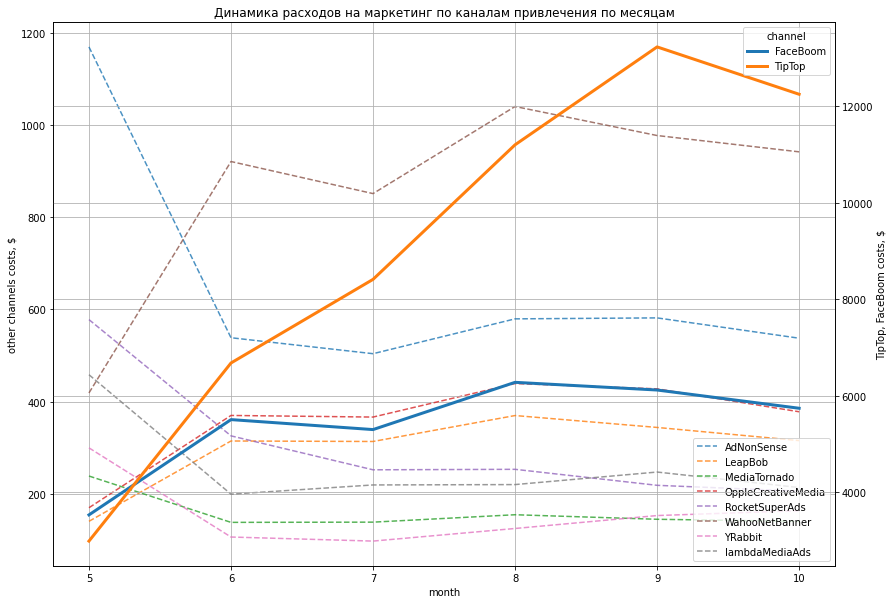

In [31]:
#Построим график распрделения расходов на маркетинг по каналам привлечения 
# с разбивкой по месяцам
# Так как затраты на два источника на порядок отличаются от других каналов,
# зададим две оси У, чтобы рассмотреть динамику 
profiles_copy=profiles.copy()
profiles_copy['week']=profiles_copy['first_ts'].dt.isocalendar().week
profiles_copy['month']=profiles_copy['first_ts'].dt.month
fig, ax1 = plt.subplots(figsize=(14,10))
(
    profiles_copy
    .query('channel != ["TipTop", "FaceBoom", "organic"]')
    .pivot_table(index=['month'], columns='channel', values='acquisition_cost', aggfunc='sum')
    .plot(grid=True, ax=ax1, style='--', alpha=0.8)
)
ax2 = ax1.twinx()
(
    profiles_copy
    .query('channel in "TipTop" or channel in "FaceBoom"')
    .pivot_table(index='month', columns='channel', values='acquisition_cost',\
                 aggfunc='sum')
    .plot(grid=True, ax=ax2, linewidth = 3)
)
ax1.set_ylabel('other channels costs, $')
ax2.set_ylabel('TipTop, FaceBoom costs, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика расходов на маркетинг по каналам привлечения по месяцам')
ax1.legend(loc=4)
plt.show()


- *В разрезе месяцев видим, что затраты на рекламу через канал TipTop выросли в 4 раза, незначительное снижение расходов по этому каналу началось в сентябре*

- *Расходы на канал FaceBoom немного увеличиваются в период с мая по июнь, но в целом остаются стабильно высокими* 
- *Среди остальных каналов расходу на рекламу увеличиваются только на источники WahooNetBanner, OppleCreativeMedia, LeapBob, расходы на другие каналы падают с мая по июнь, затем остаются стабильными*

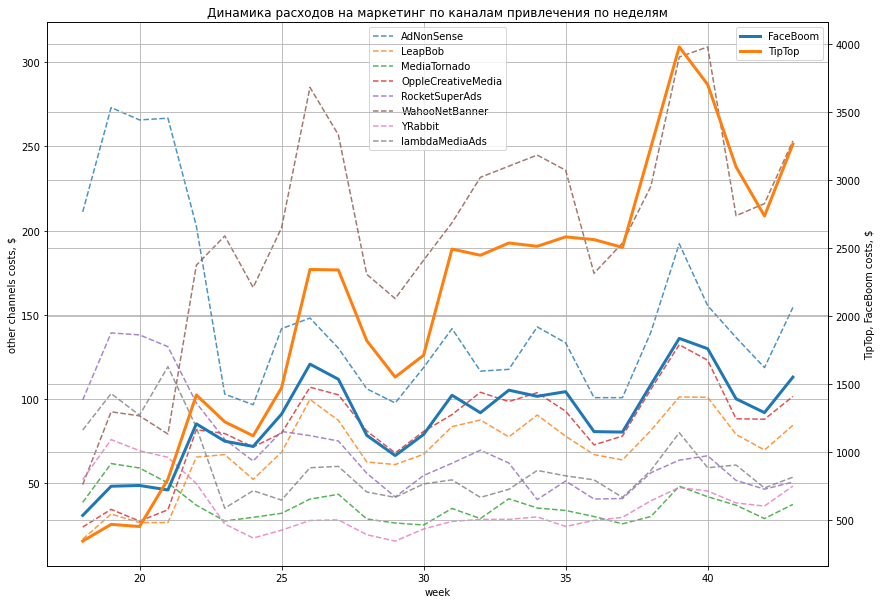

In [32]:
#Построим график распрделения расходов на маркетинг по каналам привлечения 
# с разбивкой по неделям
# Так как затраты на два источника на порядок отличаются от других каналов,
# зададим две оси У, чтобы рассмотреть динамику

fig, ax1 = plt.subplots(figsize=(14,10))
(
    profiles_copy.query('channel != ["TipTop", "FaceBoom", "organic"]')
    .pivot_table(index='week', columns='channel', values='acquisition_cost', aggfunc='sum')
    .plot(grid=True, ax=ax1, style='--', alpha=0.8)
)
ax2 = ax1.twinx()
(
    profiles_copy
    .query('channel in "TipTop" or channel in "FaceBoom"')
    .pivot_table(index='week', columns='channel', values='acquisition_cost', aggfunc='sum')
    .plot(grid=True, ax=ax2, linewidth = 3)
)
ax1.set_ylabel('other channels costs, $')
ax2.set_ylabel('TipTop, FaceBoom costs, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика расходов на маркетинг по каналам привлечения по неделям')
ax1.legend(loc=0)
ax2.legend(loc=1)
plt.show()

- *Из разбивки затрат по неделям видим, что наибольший рекламный бюджет для всех каналов выделяется приблизительно в начале каждого месяца, затем незначительно корректируется в сторону снижения в течение этого периода*
- *Наибольшие еженедельные расходы на канал TipTop, для которого наблюдается стабильное увеличение расходов в 5 раз до 31 недели (с 500 до 2500 долларов), затем они остаются стабильными в районе 2500 долларов с постепенным ростом в сентябре до 4000, но обратным снижением в октябре* 
- *Наиболее высокие расходы на канал FaceBoom также приходятся на начало месяца, но общие расходы в течение всего периода остаются стабильно высокими на уровне 1000-1500 долларов*
- *Наряду с двумя наиболее затратными каналами наиболее высоко росли затраты на канал WahooNetBanner c 50 до 275 долларов в неделю в период до 26 недели, затем после снижения до 160 долларов в период с 26 по 30 неделю начался обратный рост еженедельных расходов*  
- *для остальных каналов еженедельные расходы стабильны, с уже ранее отмеченным снижением, приходящимся на конец мая и начало июня* 

In [33]:
# Найдем средний САС с разбивкой по каналам
(
    profiles
    .pivot_table(index='channel', values='acquisition_cost', aggfunc='mean')
    .reset_index()
    .rename(columns={'acquisition_cost': 'CAC'})
    .sort_values(by='CAC', ascending=False, ignore_index=True)
)

,channel,CAC
0,TipTop,2.799003
1,FaceBoom,1.113286
2,AdNonSense,1.008054
3,lambdaMediaAds,0.724802
4,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
6,OppleCreativeMedia,0.250000
7,YRabbit,0.218975
8,MediaTornado,0.218717
9,LeapBob,0.210172


- *из таблицы видим, что наиболее высокий средний САС приходится на канал TipTop, который превышает следующий за ним канал Faceboom более, чем в два раза* 

- *средний САС для канала AdNonSense также превышает 1 доллар, по другим каналам это значение меньше доллара*  
- *наиболее низкий САС для каналов LeapBob и MediaTornado* 

**Выводы по пункту маркетинг:**

- *Всего на маркетинг было потрачено 105497 долларов, из них более 80% пришлось на два источника TipTop и FaceBoom. По сравнению с этими двумя источниками, затраты на 8 оставшиеся каналов на порядок ниже*
- *В разрезе месяцев видим, что затраты на рекламу через канал TipTop выросли в 4 раза, незначительное снижение расходов по этому каналу началось в сентябре*

- *Расходы на канал FaceBoom немного увеличиваются в период с мая по июнь, но в целом остаются стабильно высокими*

- *Среди остальных каналов расходу на рекламу увеличиваются только на источники WahooNetBanner, OppleCreativeMedia, LeapBob, расходы на другие каналы падают с мая по июнь, затем остаются стабильными*

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

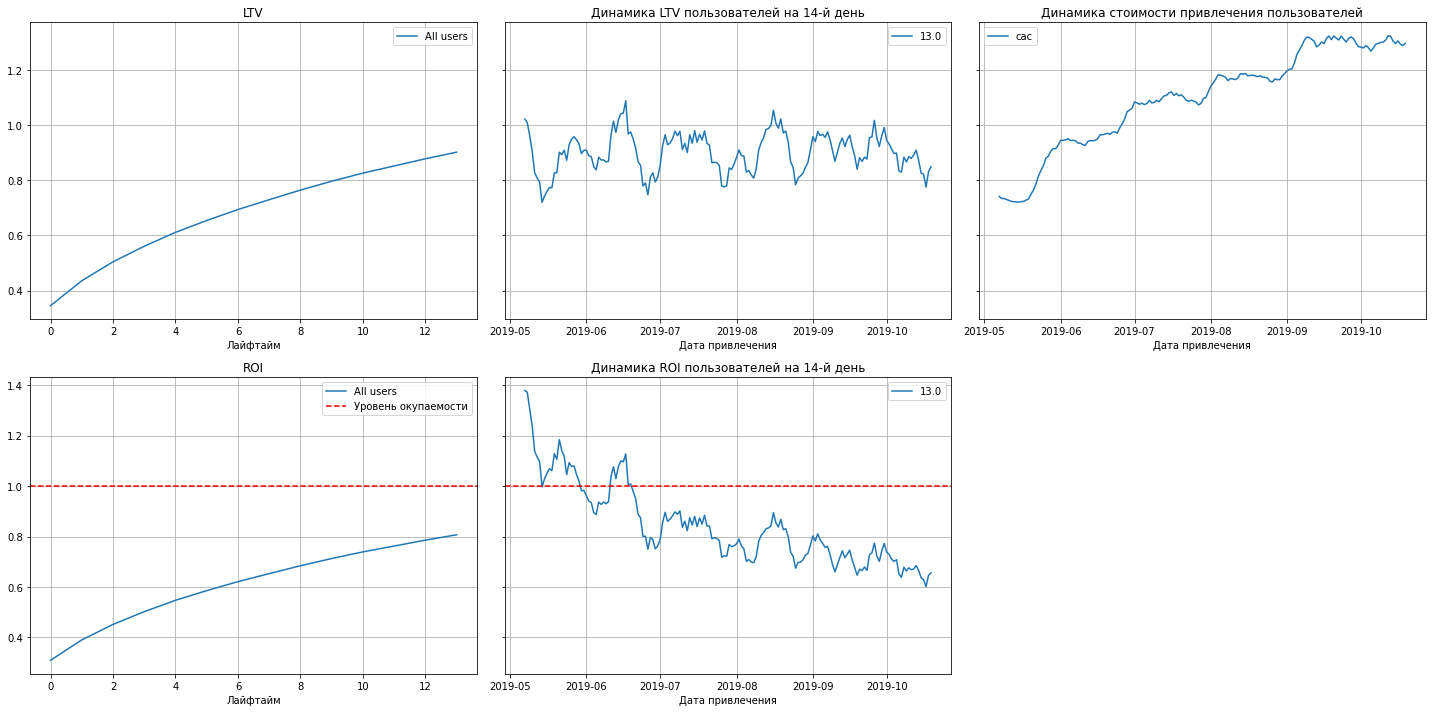

In [34]:
# исключим органических пользователей из анализа, так как они не характеризуют окупаемость рекламы
profiles=profiles.query('channel!="organic"') 
#observation_date = datetime(2019, 10, 27).date()  # зададим момент анализа
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14  # зададим горизонт анализа 
 # посчитаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
# построим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)


*Из представленных графиков видим, что реклама не окупается на 14 день, ROI составляет 80%*


*САС постоянно растет, при этом LTV 14- го дня зависит от сезонности, но достаточно стабилен. Заметного увеличения этого показателя при увеличении расходов на рекламу не отмечается*


*ROI 14-го дня стал меньше порога окупаемости, начиная с июня 2019 года, в период увеличения расходов на рекламу*

Рассмотрим подробнее, как доступные параметры влияют на окупаемость рекламы


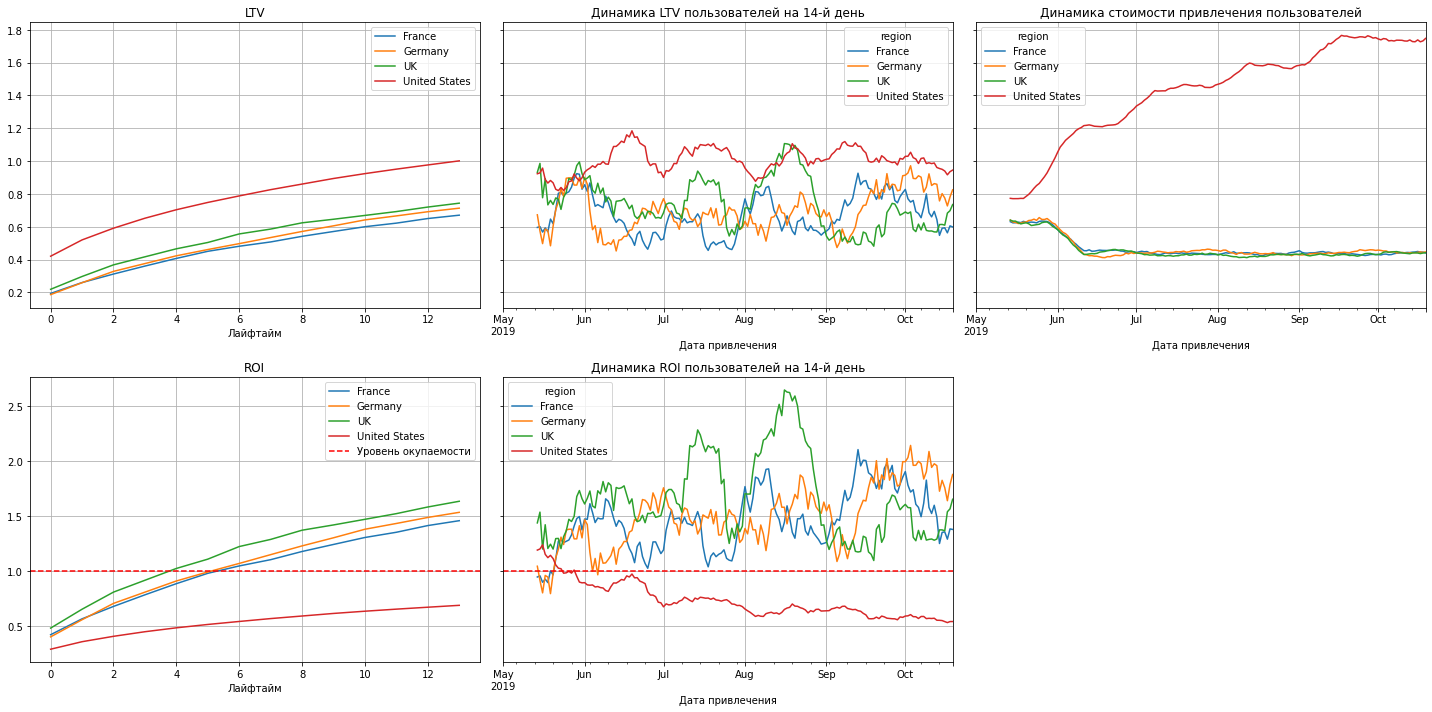

In [35]:
# смотрим окупаемость с разбивкой по странам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

*Наиболее высокий LTV у пользователей из США, однако инвестиции не окупаются, падение ROI ниже уровня окупаемости наступает в период роста инвестиий в мае-июне*


*Расходы на рекламу в США постоянно растут, при этом в остальных странах расходы снижаются с мая по июнь, затем остаются стабильными*


*В остальных странах инвестиции в рекламу окупаются на 5-й день для пользователей из Германии и Франции, и на 4-й день для пользователей из Британии*

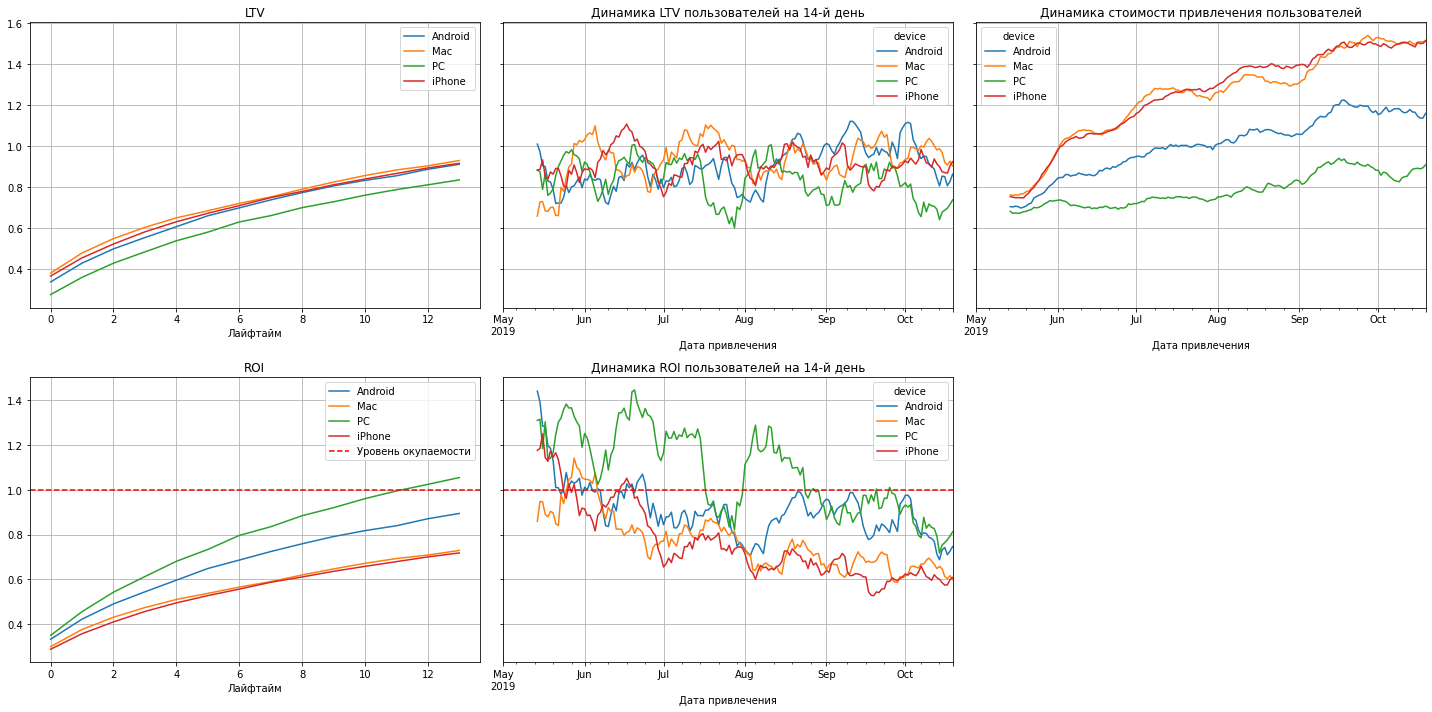

In [36]:
# смотрим окупаемость с разбивкой по устройствам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel!="organic"'), orders, observation_date, horizon_days, dimensions=['device']
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

*LTV для всех устройств находится приблизительно на одном уровне, показатель наиболее низкий для пользователей РС*


*Затраты на рекламу за 14 дней окупаются только для пользователей персональными компьютерами*


*Наиболее высокие затраты на рекламу уходят на привлечение клиентов с iphone и MAC, но их окупаемость минимальна*


*Пользователи мобильных устройств превосходили отметку окупаемости в отдельные периоды с мая по июль, затем их ROI 14-го дня стал стабильно ниже 1, что совпадает с увеличением затрат на рекламу*

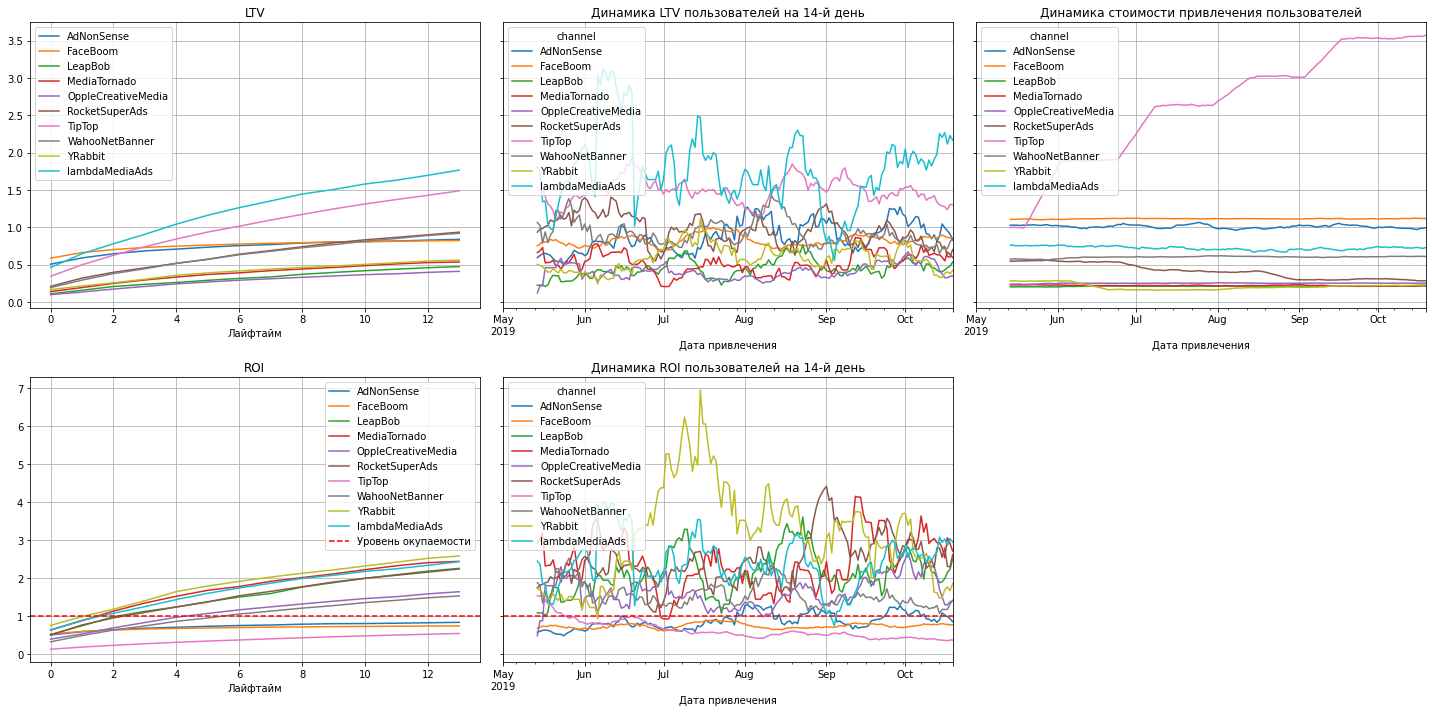

In [37]:
# смотрим окупаемость с разбивкой по каналам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

*Наиболее высокий LTV показывают каналы lambdamediaAds и TipTop*


*Каналы AdNonSense, Faceboom, TipTop не окупаются за 14 дней, данные каналы входят в лидеры по тратам на маркетинг. При этом у канала AdNonSense встречаются отдельные периоды, когда рекламные компании оказывались прибыльными,инвестиции в TipTop окупались в мае до начала стремительного увеличения расходов на маркетинг, тогда как ROI Faceboom стабильно ниже 1.* 

*Расходы на привлечение клиентов через источник TipTop постоянно растут, при этом LTV 14-го дня на всем периоде наблюдений заметно не увеличивается* 

*Для канала Faceboom расходы остаются стабильными, но также не достигают окупаемости. Несмотря на высокую конверсию, его LTV более, чем в два раза ниже по сравнению с каналом TipTop*

*Снижение общих расходов на канал AdNonSense в период с мая по июнь положительно повлияло на коэффициент окупаемости, он стал более близок к 1, а в отдельные периоды его превосходит*

*Наиболее высоко окупаются каналы Yrabbit, MediaTornado, lambdamediaAds, RocketSuperAds.Канал Yrabbit показывает аномально высокие значения окупаемости для отдельных когорт*


**Рассмотрим подробнее, почему не удается достичь окупаемости вложенных инвестиций, влияет ли на это только величина инвестиций или пользователи плохо конвертируются и удерживаются**

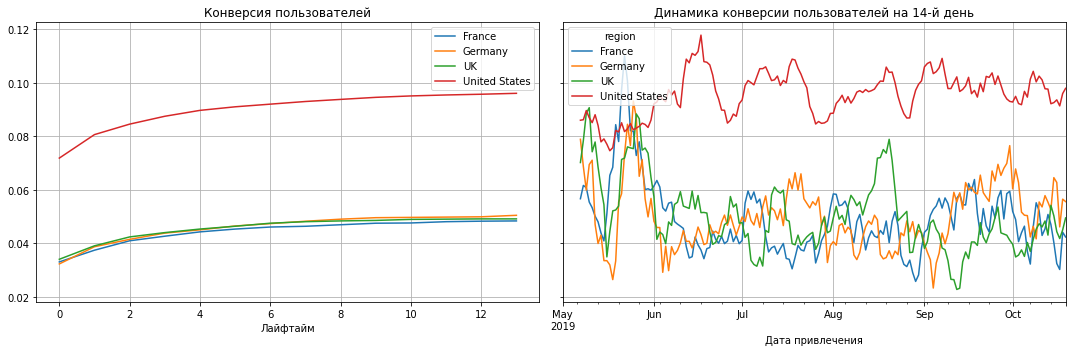

In [38]:
# Рассмотрим конверсию по регионам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

*Пользователи из США стабильно хорошо конвертируются. Конверсия в других регионах в два раза ниже, при этом в них достигается окупаемость инвестиций*

*Рассмотрим удержание клиентов по регионам*



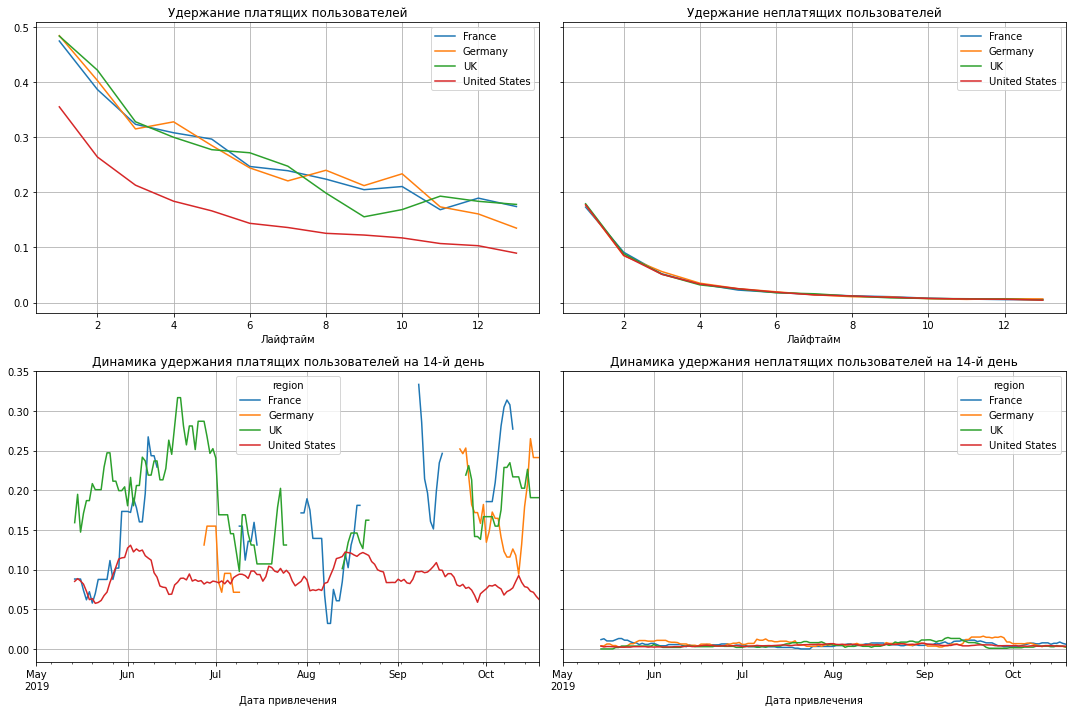

In [39]:
# смотрим удержание с разбивкой по регионам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days, window=14) 


 *Коэффциент удержания в США значительно ниже по сравнению с остальными регионами, таким образом, одна из причин неокупаемости инвестиций в США- низкий коэффициент удержания пользователей* 

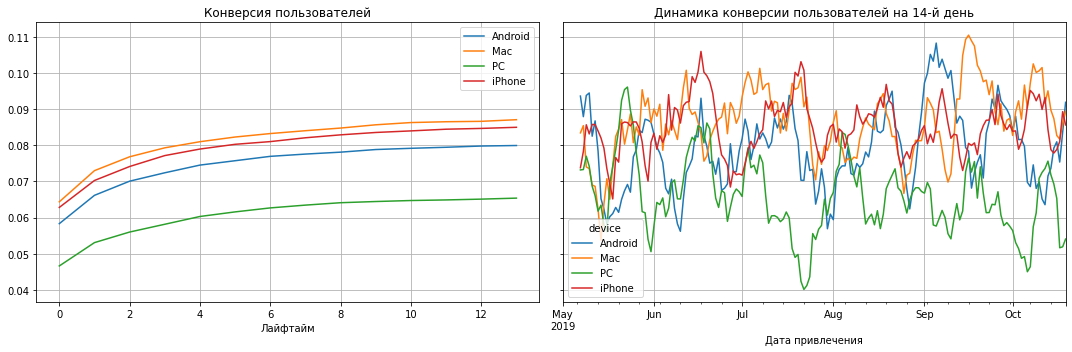

In [40]:
# Рассмотрим конверсию по устройствам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

*Пользователи ipone и mас ковертируются стабильно хорошо, конверсия на устройствах андроид ниже, но более высокая, чем у пользователей персональных компьютеров*

*Рассмотрим удержание пользователей в зависимости от устройств*

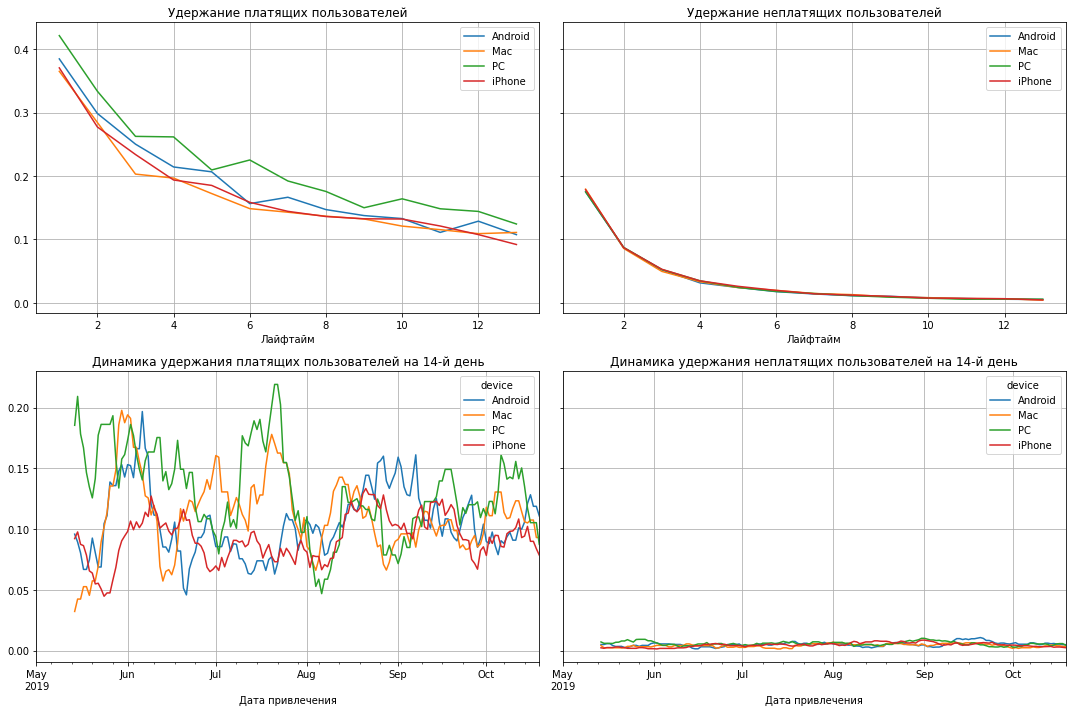

In [41]:
# смотрим удержание с разбивкой по устройствам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days, window=14) 

*Удержание пользователей для всех устройств примерно на одном уровне. Таким образом, окупаемость инвестиций для устройств Android, Mac, iphone не достигается из-за высокого уровня вложений в маркетинг, тогда как для рекламы среди пользователей персональных компьютеров эти расходы ниже*  

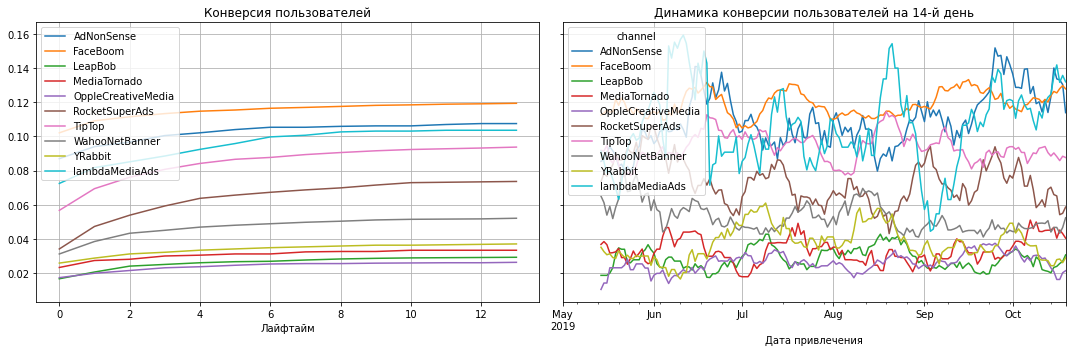

In [42]:
# Рассмотрим конверсию по каналам привлечения пользователей
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

*Каналы AdNonSense, Faceboom, TipTop, которые не достигают порога окупаемости, показывают стабильно высокую конверсию*

*Рассмотрим удержание пользователей по каналам*

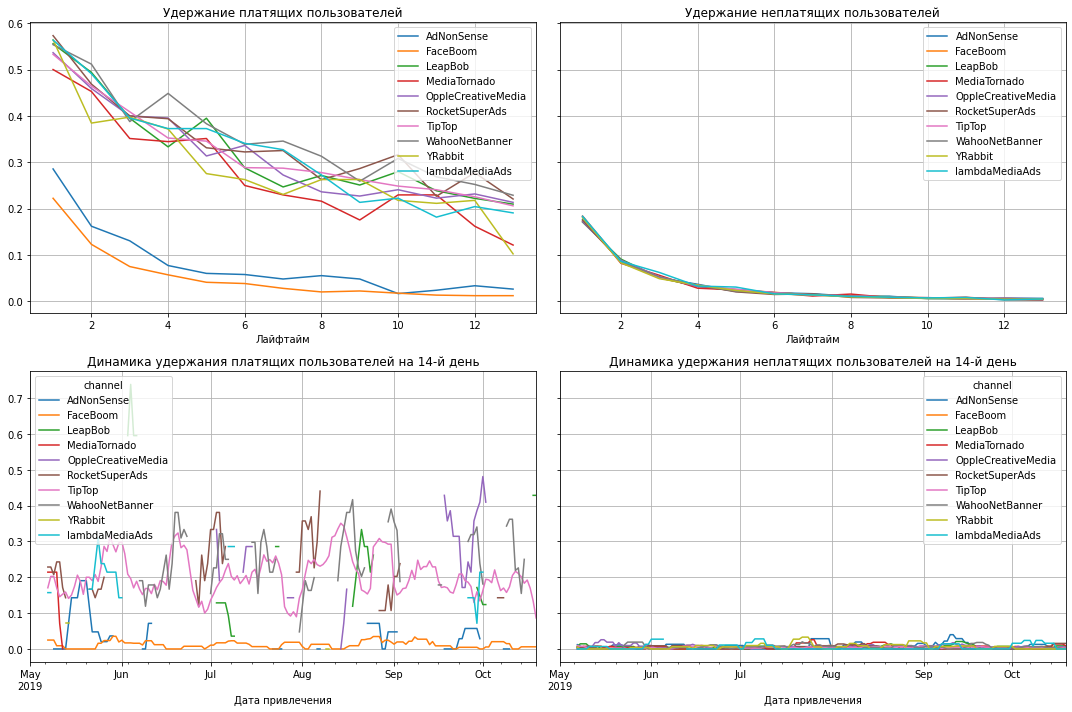

In [43]:
# смотрим удержание с разбивкой по каналам привлечения пользователей
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) 


*Каналы AdNonSense и Faceboom показывают аномально низкий коэффициент удержания пользователей, стремящийся к нулю на 14-й лайфтайм. Низкий коэффицент удержания наблюдается на всем рассматриваемом периоде. Окупаемость инвестиций в эти каналы не достигается из-за низкого уровня удержания клиентов*

*Удержание пользователей из канала TipTop на стабильно высоком уровне, таким образом, инвестиции в данный канал не окупаются из-за слишком высоких вложений, превосходящих получаемую прибыль*

**Так как американский рынок является наиболее большим для данного приложения, при этом в нем не достигается окупаемость инвестиций, рассмотрим отдельно каналы и устройства, влияющие на окупаемость и удержание клиентов в данном регионе**

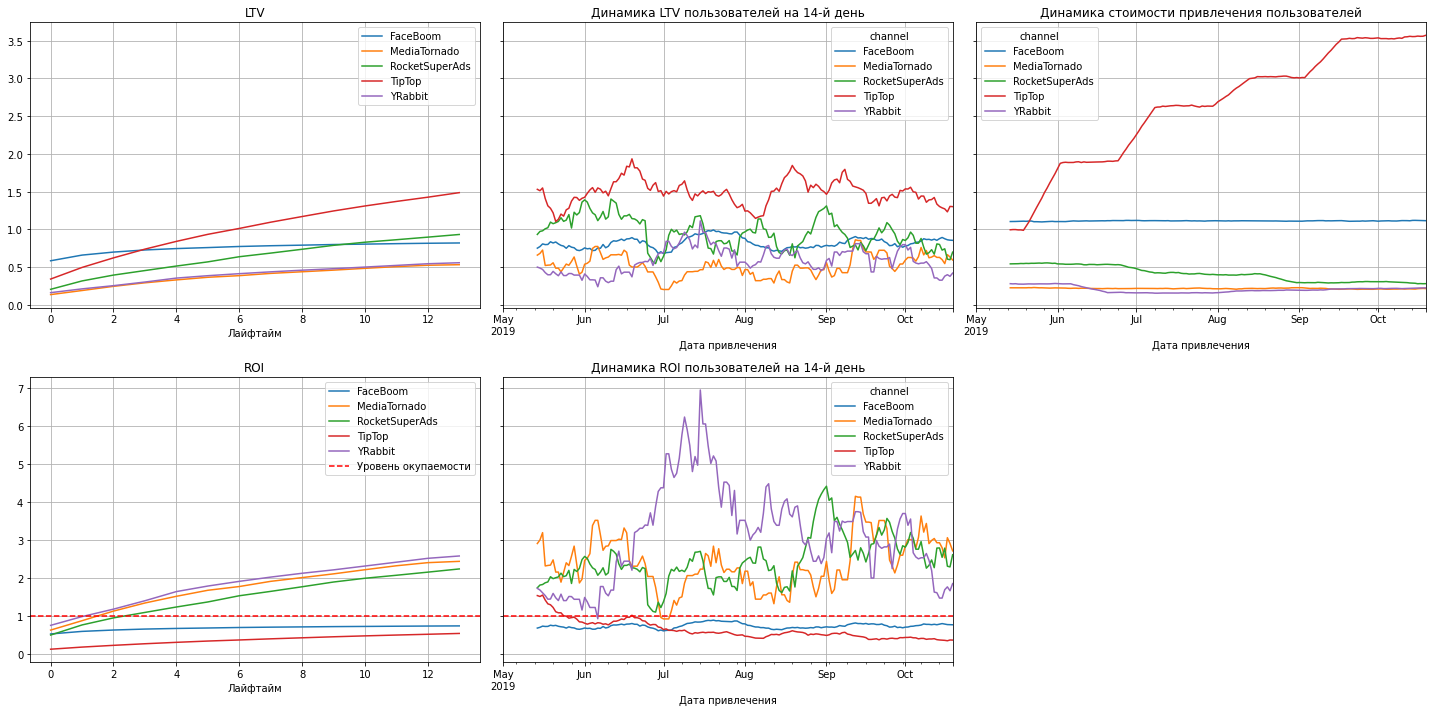

In [44]:
# строим окупаемость на американском рынке с разбивкой по каналам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region in"United States"'), orders, observation_date, \
    horizon_days, dimensions=['channel']
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

*На американском рынке каналы Yrabbit, MediaTornado, RocketSuperAds показывают наиболее высокую окупаемость. При этом в отдельные периоды ROI 14-го дня для канала Yrabbit достигает аномально высоких значений от 4 до 7*

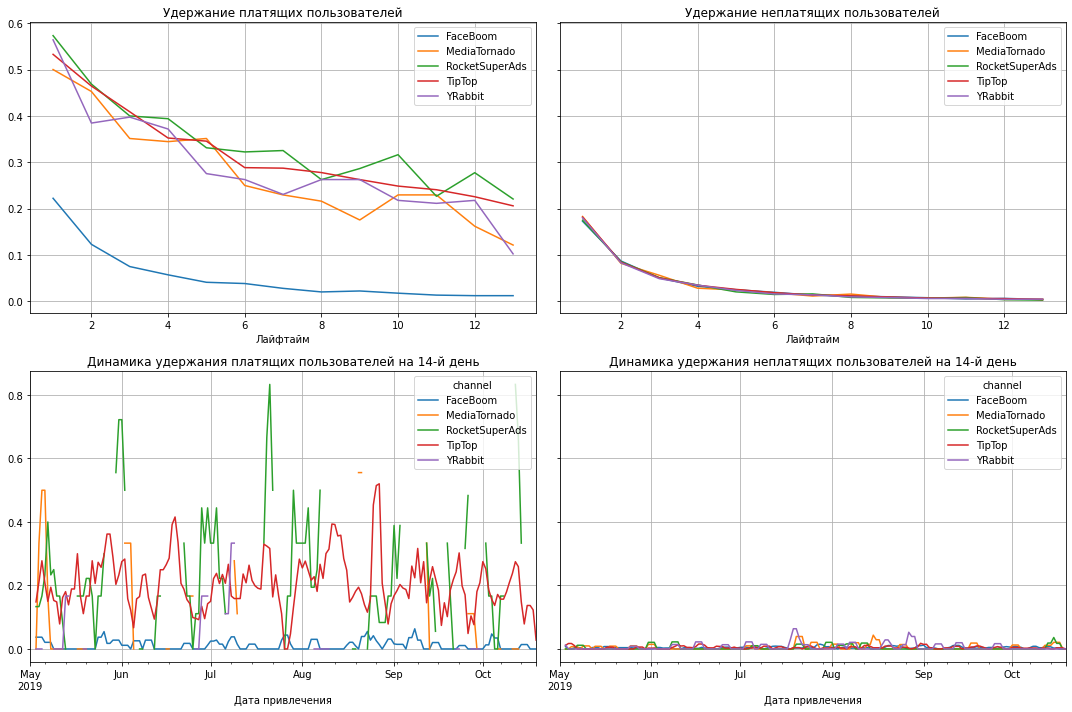

In [45]:
# строим удержание пользователей на американском рынке с разбивкой по каналам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('region in"United States"'), visits, observation_date, \
    horizon_days, dimensions=['channel']
)
plot_retention(retention_grouped, retention_history, horizon_days, window=3) 

*Канал FaceBoom привлекает наибольшее количество пользователей для американского рынка, но из-за низкого удержания пользователей, приходящих с этого канала, наблюдается низкое удержание пользователей по региону в целом*

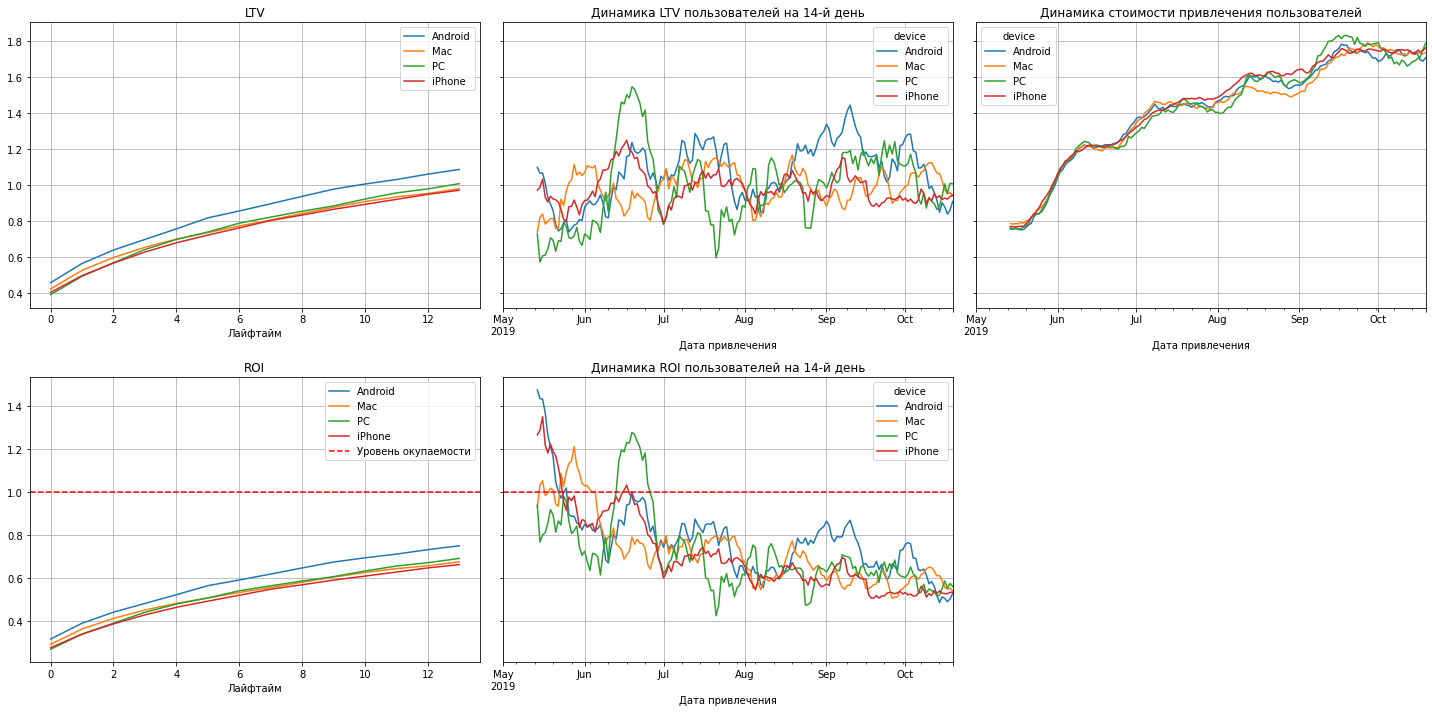

In [46]:
# строим окупаемость на американском рынке с разбивкой по устройствам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region in"United States"'), orders, observation_date, \
    horizon_days, dimensions=['device']
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

*На американском рынке инвестиции не окупаются ни для одного из устройств, при этом, как было установлено ранее, удержание клиентов для всех устройств на высоком уровне.Из графиков видим, что до июня ROI 14-го дня для  android, iphone, mac был больше 1*

*Таким образом, окупаемость для всех устройств не достигается из-за увеличивающихся расходов на маркетиннг*

**Рассмотрим возможные точки роста для европейского рынка**

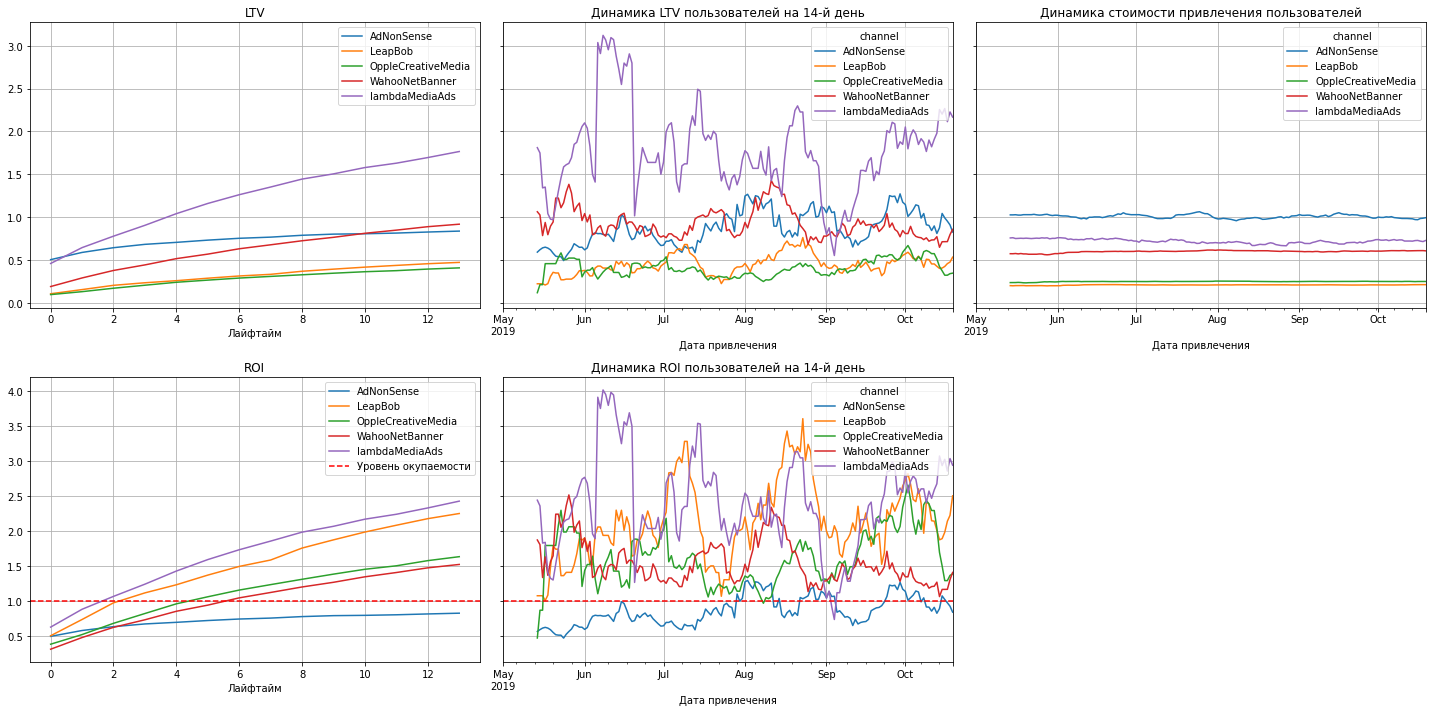

In [47]:
# строим окупаемость на европейском рынке с разбивкой по каналам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region!="United States"'), orders, observation_date,\
    horizon_days, dimensions=['channel']
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

- *Наиболее высокую окупаемость показывают каналы LambdaMediaAds и Leapbob, не достигает порога окупаемости только канал AdNonSense, при этом затраты на привлечение клиентов стабильны на всем периоде наблюдений* 
- *Для канала AdnonSense затраты на рекламу наиболее высокие, при этом, как было установлено ранее, коэффициент удержания пользователей из данного канала наиболее низкий*
- *Как отмечалось ранее, снижение расходов на канал AdNonSense положительно повлияло на окупаемость инвестиций*
- *Увеличение расходов на рекламу каналов LeapBob, OppleCreativeMedia и WahoonetBar в период с мая по июнь положительно сказалось на окупаемости инвестиций в этих каналах, при этом средние расходы на привлечение одного клиента не изменились* 

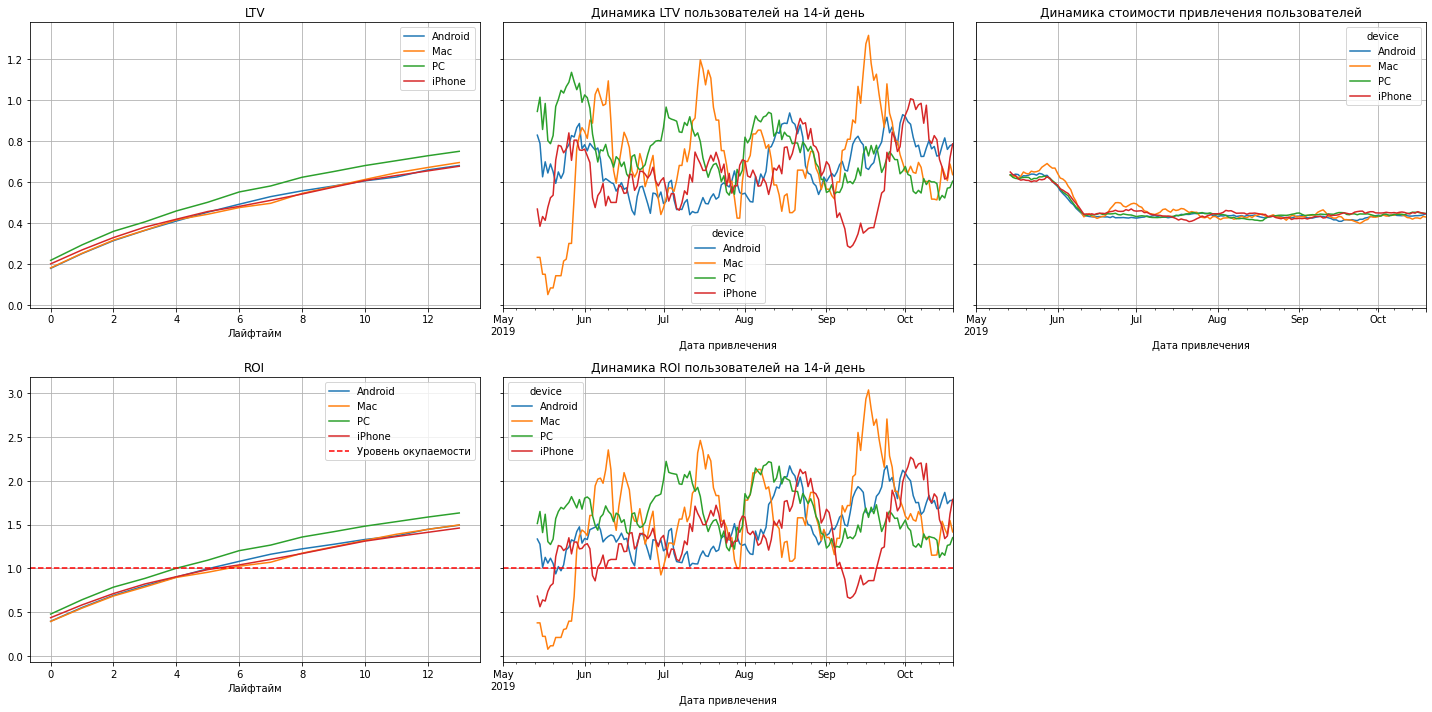

In [48]:
# строим окупаемость на европейском рынке с разбивкой по устройствам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region!="United States"'), orders, observation_date, \
    horizon_days, dimensions=['device']
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

*Затраты на привлечение клиентов по всем устройствам на европейском рынке окупаются. При этом видим, что с мая по июнь ROI 14-го дня для пользователей Mac был ниже 1, при этом также для Mac отмечался низкий LTV 14-го дня*

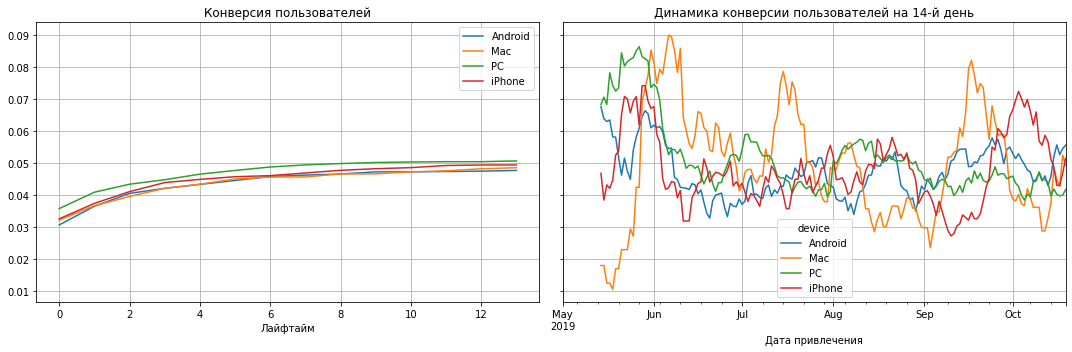

In [49]:
# Рассмотрим конверсию по устройствам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
   profiles.query('region!="United States"'), orders,\
    observation_date, horizon_days, dimensions=['device']
)
# строим график
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14)

*Из графика видим, что в период c мая по июнь наблюдалась низкая конверсия для пользователей Mac, возможно, это было связано с некорректной работой приложения в этом периоде. Однако, уже в июне конверсия выходит на стабильный уровень, при этом снижаются затраты на рекламы, и кампания выходит на порог окупаемости для всех устройств*

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

**Анализ окупаемости рекламы по регионам показал следующее:**

- *В США инвестиции не окупаются, падение ROI ниже уровня окупаемости наступает в период роста инвестиий в мае-июне*

- *Расходы на рекламу в США постоянно растут, при этом в остальных странах расходы снижаются с мая по июнь, затем остаются стабильными*

- *В остальных странах инвестиции в рекламу окупаются на 5-й день для пользователей из Германии и Франции, и на 4-й день для пользователей из Британии*

- *Пользователи из США стабильно хорошо конвертируются. Конверсия в других регионах в два раза ниже, при этом в них достигается окупаемость инвестиций*

- *Коэффциент удержания пользователей в США значительно ниже по сравнению с остальными регионами, таким образом окупаемость инвестиций в США не достигается не только из-за высоких инвестиций в маркетинг, но и из-за низкого коэффициента удержания пользователей*

**Анализ окупаемости рекламы по устройствам показал следующее:**

- *Затраты на рекламу за 14 дней окупаются только для пользователей персональными компьютерами*

- *Наиболее высокие затраты на рекламу уходят на привлечение клиентов с iphone и MAC, но их окупаемость минимальна*

- *Пользователи мобильных устройств превосходили отметку окупаемости в отдельные периоды с мая по июль, затем их ROI 14-го дня стал стабильно ниже 1, что совпадает с увеличением затрат на рекламу*

- *Удержание пользователей для всех устройств примерно на одном уровне. Таким образом, окупаемость инвестиций для устройств Android, Mac, iphone не достигается из-за высокого уровня вложений в маркетинг  и не зависит от типа устройств, тогда как для рекламы среди пользователей персональных компьютеров эти расходы ниже*  

**Анализ окупаемости рекламы по каналам привлечения показал следующее:**

- *Каналы AdNonSense, Faceboom, TipTop не окупаются за 14 дней, данные каналы входят в лидеры по тратам на маркетинг. При этом у канала AdNonSense встречаются отдельные периоды, когда рекламные компании оказывались прибыльными, инвестиции в TipTop окупались в мае до начала стремительного увеличения расходов на маркетинг, тогда как ROI Faceboom стабильно ниже 1.* 

- *Расходы на привлечение клиентов через источник TipTop постоянно растет, тогда как для канала Faceboom он остается стабильным, но также не достигает окупаемости*

- *Наиболее высоко окупаются каналы Yrabbit, MediaTornado, lambdamediaAds, RocketSuperAds. Канал Yrabbit показывает аномально высокие значения окупаемости для отдельных когорт*

- *Каналы AdNonSense и Faceboom показывают аномально низкий коэффициент удержания пользователей, стремящийся к нулю на 14-й лайфтайм. Низкий коэффицент удержания наблюдается на всем рассматриваемом периоде. Окупаемость инвестиций в эти каналы не достигается из-за низкого уровня удержания клиентов*

- *Удержание пользователей из канала TipTop на стабильно высоком уровне, при этом LTV остается на стабильно уровне без заметного увеличения, таким образом, инвестиции в данный канал не окупаются из-за слишком высоких вложений, превосходящих получаемую прибыль*

- *снижение расходов с мая по июнь на канал AdNonSense положительно повлияло на окупаемость инвестиций, ROI стал более близок к 1*

- *Увеличение расходов на рекламу каналов LeapBob, OppleCreativeMedia и WahoonetBar в период с мая по июнь положительно сказалось на окупаемости инвестиций в этих каналах*

**Выводы по окупаемости рекламы:**


- *реклама на продвижение приложения не окупается на 14 день, ROI составляет 80%*

- *САС постоянно растет, при этом LTV 14- го дня зависит от сезонности, но достаточно стабилен*

- *ROI 14-го дня стал меньше порога окупаемости, начиная с июня 2019 года, в период увеличения расходов на рекламу*

- *Убыточным регионом является США, в котором не достигается окупаемость маркетинговых инвестиций, при этом более 80% рекламного бюджета приходится на этот регион*

- *На европейском рынке единственным убыточным каналом рекламы является AdnonSense, для которого затраты на рекламу наиболее высокие в данном регионе, при этом коэффициент удержания пользователей из данного канала наиболее низкий*

**Причины низкой окупаемости инвестиций в США:**
- *Более половины рекламного бюджета уходит на продвижение канала TipTop, который, несмотря на высокий уровень удержания клиентов и конверсию, остается убыточным. Расходы на этот канал стабильно возрастали на всём периоде наблюдения, при этом LTV не изменялся* 
- *30% рекламного бюджета расходуется на канал FaceBoom, который имеет очень низкий уровень удержания пользователей* 
- *из-за высоких расходов на маркетинг не окупается реклама ни для одного из устройств, которые используют пользователи приложения, при этом индекс удержания на всех устройствах стабильный, то есть работа приложения не зависит от типа устройства пользователя*
- *по сравнению с европейским регином в США стабильно увеличиваются инвестиции в рекламу, при этом из-за некачественного источника трафика в виде канала FaceBoom уровень удержания платящих пользователей низкий, уровень LTV заметно не изменяется, что не позволяет обеспечить окупаемость* 

**Рекомендации в отдел маркетинга:**
- *Необходимо пересмотреть рекламный бюджет для США и снизить траты как минимум до уровня мая 2019 года, когда достигался порог окупаемости*
- *Так как наиболее высокие траты приходятся на канал TipTop, но данный канал обеспечивает высокую конверсию, стабильное удержание клиентов и высокий LTV, его убыточность связана с избыточными расходами на рекламу. Необходимо снизить расходы на этот канал до порога окупаемости с САС около 1 доллара*
- *Так как канал FaceBoom обеспечивает высокую конверсию, привлекает большое количество пользователей и имеет высокий LTV, необходимо установить причины низкого удержания клиентов. Возможно, другие каналы наиболее эффективным способом напоминают о приложении, что стимулирует повторные покупки клиентов. На период выяснения причин низкого удержания пользователей необходимо сократить расходы на этот канал до достижения уровня окупаемости с САС до 0,5 долларов*
- *необходимо обратить внимание на перспективный канал американского рынка RocketSuperAds, который обеспечивает высокую конверсию в 8%, высокий LTV и ROI* 
- *Каналы Yrabbit и MediaTornado, несмотря на быструю окупаемость, имеют невысокую конверсию, общее количество платящих пользователей из этих каналов в представленной выборке невысокое, в этой связи нельзя спрогнозировать, что при увеличении расходов на эти источники и привлечении новых пользователей окупаемость останется на том же уровне. Рекомендуется постепенное увеличение инвестиций для отслеживания трендов окупаемости при увеличении числа выборки пользователей*
- *на европейском рынке необходимо установить причины низкого удержания пользователей из канала AdNonSense, до установления причины необходимо сократить инвестиции в данный канал до уровня окупаемости*
- *на европейском рынке рекомендуется увеличить расходы на канал lambdamediaAds, который обеспечивает высокую конверсию и быструю окупаемость*
- *Канал WahooNetBanner имеет достаточный уровень инвестиций, который обеспечивает быструю окупаемость*
- *Каналы LeapBob и OppleCreative media привлекают много пользователей и без высокого рекламного бюджета, но имеют низкую конверсию, при этом из графика изменения общих расходов на маркетинг установлено, что увеличение инвестиций в эти каналы в мае-июне позволяет привлечь больше платящих пользователей,  ROI в этот период увеличивается. Так как выборка платящих пользователей сэтих каналов невысокая, рекомендуется постепенное увеличение общих расходов с сохранением САС на прежнем уровне*
- *Чтобы повысить удержание для пользователей из США, рекомендуется рассмотреть введение персонализированных UX-стратегий, e-mail рассылок, персональных рекомендаций, push-уведомлений. Можно ввести определённые "награды" или привилегии для постоянных пользователей* 
- *Для канала FaceBoom можно настроить более таргетированное привлечение, направленное на пользователей с необходимыми характеристиками. Также, можно ввести поощрение пользователей за репосты контента и прочий социальный engagement, связанный с приложением, в данном канале*
